In [26]:
#!/usr/bin/env python3

<div class="alert alert-block alert-info" style="text-align: center;">
<span style="font-size: 20px;"><b> Complete script to load GBS data interactively and create 2D plots
of theta profiles with equilibrium contours </b></span><br>
</div>

In [35]:
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoMinorLocator

In [36]:
# Directory path
directory = "/zhisongqu_data/kyungtak/data_GBS/GBS_SN/nu_scan/SN_nu1"

In [33]:

files = sorted(glob.glob(os.path.join(directory, "results_*.h5")))
print(f"Found {len(files)} files")

file_time_ranges = {}
all_times = []

for file_path in files:
    filename = os.path.basename(file_path)
    file_num = int(filename.split('_')[1].split('.')[0])
    
    try:
        with h5py.File(file_path, 'r') as f:
            if 'data/var3d/time' in f:
                times = f['data/var3d/time'][...]
                file_time_ranges[file_num] = (times.min(), times.max())
                all_times.extend(times)
                print(f"  File {file_num:02d}: {len(times)} time points, range [{times.min():.3f}, {times.max():.3f}]")
    except Exception as e:
        print(f"  Error reading {filename}: {e}")

all_times = np.array(sorted(all_times))

# Step 2: Ask user for time window
print(f"\nTotal time range available: [{all_times.min():.3f}, {all_times.max():.3f}]")

while True:
    try:
        t_start = float(input(f"Enter start time (min: {all_times.min():.3f}): "))
        t_end = float(input(f"Enter end time (max: {all_times.max():.3f}): "))
        
        if t_start >= t_end:
            print("Start time must be less than end time!")
            continue
            
        if t_start < all_times.min() or t_end > all_times.max():
            print("Time range outside available data!")
            continue
            
        break
        
    except ValueError:
        print("Please enter valid numbers!")

# Step 3: Find relevant files
relevant_files = []

for file_num, (file_t_min, file_t_max) in file_time_ranges.items():
    if file_t_max >= t_start and file_t_min <= t_end:
        relevant_files.append(file_num)

relevant_files = sorted(relevant_files)
print(f"\nFiles containing data in range [{t_start:.3f}, {t_end:.3f}]: {relevant_files}")

# Step 4: Ask which variable to load
variable = input("\nEnter variable to load (default: theta): ").strip()
if not variable:
    variable = 'theta'

# Step 5: Load data from relevant files
loaded_times = []
loaded_file_numbers = []
loaded_data = []
dataset_names = []  # Track which dataset each corresponds to

print(f"\nLoading {variable} data from relevant files...")

for file_num in relevant_files:
    file_path = os.path.join(directory, f"results_{file_num:02d}.h5")
    print(f"  Loading from file {file_num:02d}...")
    
    try:
        with h5py.File(file_path, 'r') as f:
            # Load times
            all_file_times = f['data/var3d/time'][...]
            
            # Find time indices within our range
            time_mask = (all_file_times >= t_start) & (all_file_times <= t_end)
            selected_times = all_file_times[time_mask]
            time_indices = np.where(time_mask)[0]
            
            if len(selected_times) == 0:
                print(f"    No data in time range for file {file_num:02d}")
                continue
            
            print(f"    Found {len(selected_times)} time points in range")
            
            # Load the specified variable
            var_path = f'data/var3d/{variable}'
            if var_path in f:
                var_group = f[var_path]
                
                # Get all dataset names (excluding coordinate arrays)
                dataset_keys = [key for key in var_group.keys() 
                               if not key.startswith('coord') and isinstance(var_group[key], h5py.Dataset)]
                
                print(f"    Available datasets: {len(dataset_keys)}")
                
                # Match time indices to dataset names
                for i, time_idx in enumerate(time_indices):
                    if time_idx < len(dataset_keys):
                        dataset_name = dataset_keys[time_idx]
                        
                        # Load the 3D spatial data for this time point
                        var_data = var_group[dataset_name][...]
                        
                        # Store the data
                        loaded_times.append(selected_times[i])
                        loaded_file_numbers.append(file_num)
                        loaded_data.append(var_data)
                        dataset_names.append(dataset_name)
                        
                        print(f"    Loaded dataset {dataset_name}: shape {var_data.shape} for time {selected_times[i]:.3f}")
            else:
                print(f"    Variable {variable} not found in file {file_num:02d}")
    
    except Exception as e:
        print(f"    Error loading {file_num:02d}: {e}")

# Step 6: Convert to numpy arrays and sort by time
loaded_times = np.array(loaded_times)
loaded_file_numbers = np.array(loaded_file_numbers)
dataset_names = np.array(dataset_names)

if len(loaded_times) > 0:
    # Convert loaded_data to numpy array: (time_points, z, x, y)
    loaded_data = np.array(loaded_data)
    
    # Sort everything by time
    sort_indices = np.argsort(loaded_times)
    loaded_times = loaded_times[sort_indices]
    loaded_file_numbers = loaded_file_numbers[sort_indices]
    loaded_data = loaded_data[sort_indices]
    dataset_names = dataset_names[sort_indices]

# Now you have:
# - loaded_times: array of time values
# - loaded_file_numbers: which file each time point came from
# - loaded_data: 3D array (time, spatial_y, spatial_x) of your variable data
print(f"\nAvailable variables:")
print(f"- loaded_times: {loaded_times.shape if len(loaded_times) > 0 else 'empty'}")
print(f"- loaded_file_numbers: {loaded_file_numbers.shape if len(loaded_file_numbers) > 0 else 'empty'}")
print(f"- loaded_data: {loaded_data.shape if len(loaded_data) > 0 else 'empty'}")

Found 92 files
  File 00: 21 time points, range [0.000, 2.000]
  File 01: 12 time points, range [2.100, 3.200]
  File 02: 12 time points, range [3.300, 4.400]
  File 03: 11 time points, range [4.500, 5.500]
  File 04: 12 time points, range [5.600, 6.700]
  File 05: 11 time points, range [6.800, 7.800]
  File 06: 17 time points, range [7.900, 9.500]
  File 07: 17 time points, range [9.600, 11.200]
  File 08: 16 time points, range [11.300, 12.800]
  File 09: 15 time points, range [12.900, 14.300]
  File 10: 15 time points, range [14.400, 15.800]
  File 11: 16 time points, range [15.900, 17.400]
  File 12: 15 time points, range [17.500, 18.900]
  File 13: 15 time points, range [19.000, 20.400]
  File 14: 16 time points, range [20.500, 22.000]
  File 15: 15 time points, range [22.100, 23.500]
  File 16: 15 time points, range [23.600, 25.000]
  File 17: 15 time points, range [25.100, 26.500]
  File 18: 15 time points, range [26.600, 28.000]
  File 19: 15 time points, range [28.100, 29.500]


Enter start time (min: 0.000):  158
Enter end time (max: 159.500):  


Please enter valid numbers!


Enter start time (min: 0.000):  158
Enter end time (max: 159.500):  159



Files containing data in range [158.000, 159.000]: [90, 91]



Enter variable to load (default: theta):  



Loading theta data from relevant files...
  Loading from file 90...
    Found 2 time points in range
    Available datasets: 15
    Loaded dataset 001581: shape (80, 244, 324) for time 158.000
    Loaded dataset 001582: shape (80, 244, 324) for time 158.100
  Loading from file 91...
    Found 8 time points in range
    Available datasets: 14
    Loaded dataset 001583: shape (80, 244, 324) for time 158.200
    Loaded dataset 001584: shape (80, 244, 324) for time 158.300
    Loaded dataset 001585: shape (80, 244, 324) for time 158.400
    Loaded dataset 001586: shape (80, 244, 324) for time 158.500
    Loaded dataset 001587: shape (80, 244, 324) for time 158.600
    Loaded dataset 001588: shape (80, 244, 324) for time 158.700
    Loaded dataset 001589: shape (80, 244, 324) for time 158.800
    Loaded dataset 001590: shape (80, 244, 324) for time 158.900

Available variables:
- loaded_times: (10,)
- loaded_file_numbers: (10,)
- loaded_data: (10, 80, 244, 324)


In [34]:
loaded_data.shape

(10, 80, 244, 324)

# Grid

In [52]:
nx, ny = Psi.shape  # (244, 324)
x = np.linspace(-3.75, 603.75, nx)  # 244 points in x
y = np.linspace(-3.75, 803.75, ny)  # 324 points in y

# The meshgrid creation is correct
X, Y = np.meshgrid(x, y, indexing='ij')

# Background B-field

Loading equilibrium data...
Psi shape: (244, 324)
dpsidx_v shape: (244, 324)
dpsidy_v shape: (244, 324)
Calculating poloidal magnetic field...
Finding X-point...
X-point indices: iyxpt=121, ixxpt=74
X-point coordinates: x=181.250, y=298.750
Psi at X-point: 115365.981191
Bpol at X-point: 0.118616


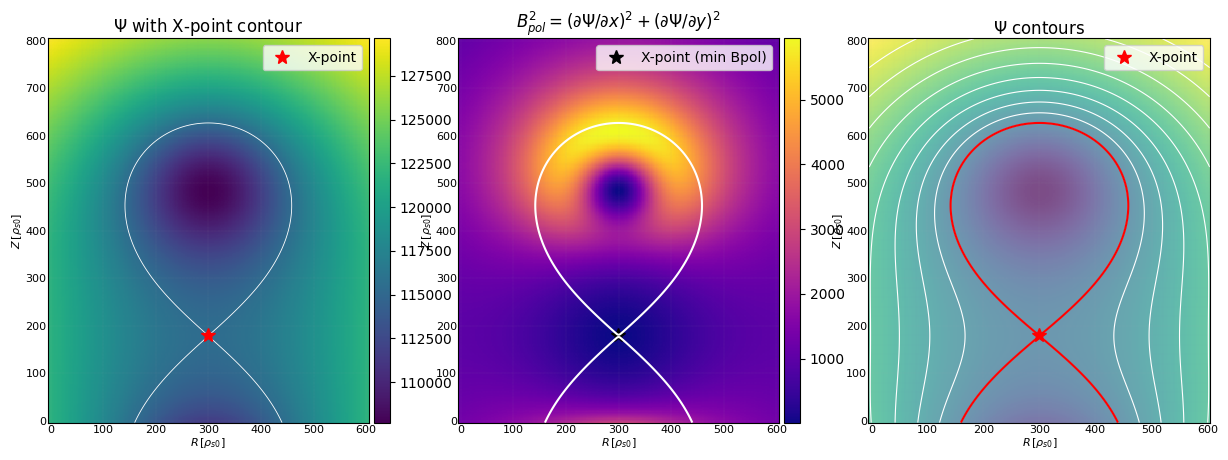


X-POINT ANALYSIS SUMMARY
File: /zhisongqu_data/kyungtak/data_GBS/GBS_SN/nu_scan/SN_nu1/results_91.h5
Grid size: 244 x 324
X-point indices: (iy=121, ix=74)
X-point coordinates: (181.250, 298.750)
Psi at X-point: 115365.981191
Min Bpol value: 0.118616
Max Psi value: 129651.813633
Min Psi value: 107655.802867

Variables created:
- Psi: poloidal flux
- Bpol: poloidal magnetic field magnitude squared
- X, Y: coordinate meshgrids
- ixxpt, iyxpt: X-point indices
- x, y: coordinate arrays


In [62]:

file_path = "/zhisongqu_data/kyungtak/data_GBS/GBS_SN/nu_scan/SN_nu1/results_91.h5"

# Load equilibrium data
print("Loading equilibrium data...")
with h5py.File(file_path, 'r') as f:
    # Load Psi and its derivatives
    Psi = f['equil/Psi'][...]
    dpsidx_v = f['equil/dpsidx_v'][...]
    dpsidy_v = f['equil/dpsidy_v'][...]
    
    print(f"Psi shape: {Psi.shape}")
    print(f"dpsidx_v shape: {dpsidx_v.shape}")
    print(f"dpsidy_v shape: {dpsidy_v.shape}")

# Calculate Bpol (poloidal magnetic field magnitude squared)
print("Calculating poloidal magnetic field...")
Bpol = dpsidx_v**2 + dpsidy_v**2

# Find X-point coordinates (minimum of Bpol where Bpol > 0)
print("Finding X-point...")
Xpt_coord = np.unravel_index(np.argmin(Bpol[Bpol > 0]), dpsidx_v.shape)
ixxpt = Xpt_coord[1]  # x-coordinate index
iyxpt = Xpt_coord[0]  # y-coordinate index

print(f"X-point indices: iyxpt={iyxpt}, ixxpt={ixxpt}")
print(f"X-point coordinates: x={x[ixxpt]:.3f}, y={y[iyxpt]:.3f}")
print(f"Psi at X-point: {Psi[iyxpt, ixxpt]:.6f}")
print(f"Bpol at X-point: {Bpol[iyxpt, ixxpt]:.6f}")

# Create plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=100)

# Plot 1: Psi with X-point contour
ax = axes[0]
cs1 = ax.pcolormesh(X, Y, Psi, cmap='viridis', shading='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar1 = fig.colorbar(cs1, cax=cax, orientation='vertical')
cbar1.ax.tick_params(labelsize=10)

# Add X-point contour
ax.contour(X, Y, Psi, levels=[Psi[iyxpt, ixxpt]], colors='w', linewidths=0.6, linestyles='-')

# Mark X-point location
ax.plot(X[iyxpt, ixxpt], Y[iyxpt, ixxpt], 'r*', markersize=10, label='X-point')
ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
ax.grid(True, which='minor', alpha=0.2, linestyle=':', linewidth=0.1)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='x', labelsize=8, pad=1)
ax.tick_params(axis='y', labelsize=8, pad=1)
ax.tick_params(which='minor', direction="in", size=0)
ax.tick_params(which='major', direction="in", size=0)
ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=8, labelpad=1)
ax.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=8, rotation=90, labelpad=1)
ax.set_title(r'$\Psi$ with X-point contour', fontsize=12, pad=1.5)
ax.legend()

# Plot 2: Bpol (poloidal magnetic field)
ax = axes[1]
cs2 = ax.pcolormesh(X, Y, Bpol, cmap='plasma', shading='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar2 = fig.colorbar(cs2, cax=cax, orientation='vertical')
cbar2.ax.tick_params(labelsize=10)

# Mark X-point location
ax.plot(X[iyxpt, ixxpt], Y[iyxpt, ixxpt], 'k*', markersize=10, label='X-point (min Bpol)')
ax.contour(X, Y, Psi, levels=[psi_xpt], colors='w', linewidths=1.5, linestyles='-')


# Styling
ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
ax.grid(True, which='minor', alpha=0.2, linestyle=':', linewidth=0.1)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='x', labelsize=8, pad=1)
ax.tick_params(axis='y', labelsize=8, pad=1)
ax.tick_params(which='minor', direction="in", size=0)
ax.tick_params(which='major', direction="in", size=0)

ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=8, labelpad=1)
ax.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=8, rotation=90, labelpad=1)
ax.set_title(r'$B_{pol}^2 = (\partial\Psi/\partial x)^2 + (\partial\Psi/\partial y)^2$', fontsize=12, pad=1.5)
ax.legend()

# Plot 3: Multiple Psi contours
ax = axes[2]
cs3 = ax.pcolormesh(X, Y, Psi, cmap='viridis', shading='auto', alpha=0.7)

# Plot multiple contour levels
psi_xpt = Psi[iyxpt, ixxpt]
psi_levels = np.linspace(psi_xpt, Psi.max(), 10)
contours = ax.contour(X, Y, Psi, levels=psi_levels, colors='white', linewidths=0.8)

# Highlight the X-point contour
ax.contour(X, Y, Psi, levels=[psi_xpt], colors='red', linewidths=1.5, linestyles='-')

# Mark X-point location
ax.plot(X[iyxpt, ixxpt], Y[iyxpt, ixxpt], 'r*', markersize=10, label='X-point')

# Styling
ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
ax.grid(True, which='minor', alpha=0.2, linestyle=':', linewidth=0.1)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='x', labelsize=8, pad=1)
ax.tick_params(axis='y', labelsize=8, pad=1)
ax.tick_params(which='minor', direction="in", size=0)
ax.tick_params(which='major', direction="in", size=0)

ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=8, labelpad=1)
ax.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=8, rotation=90, labelpad=1)
ax.set_title(r'$\Psi$ contours', fontsize=12, pad=1.5)
ax.legend()

plt.show()

# Print summary
print("\n" + "="*50)
print("X-POINT ANALYSIS SUMMARY")
print("="*50)
print(f"File: {file_path}")
print(f"Grid size: {nx} x {ny}")
print(f"X-point indices: (iy={iyxpt}, ix={ixxpt})")
print(f"X-point coordinates: ({x[ixxpt]:.3f}, {y[iyxpt]:.3f})")
print(f"Psi at X-point: {Psi[iyxpt, ixxpt]:.6f}")
print(f"Min Bpol value: {Bpol[Bpol > 0].min():.6f}")
print(f"Max Psi value: {Psi.max():.6f}")
print(f"Min Psi value: {Psi.min():.6f}")

# Save the important variables for later use
print("\nVariables created:")
print("- Psi: poloidal flux")
print("- Bpol: poloidal magnetic field magnitude squared")
print("- X, Y: coordinate meshgrids")  
print("- ixxpt, iyxpt: X-point indices")
print("- x, y: coordinate arrays")

# Calculate mean and fluctuating quantity

In [63]:

# Average in time and toroidal direction
loaded_data_time_avg  = np.mean(loaded_data, axis=0); 
loaded_data_tor_avg  = np.mean(loaded_data, axis=1); 

loaded_data_fluct   = np.sqrt((loaded_data[:,0,:,:]-loaded_data_tor_avg)**2) / loaded_data_tor_avg
loaded_data_fluct_avg = np.mean(loaded_data_fluct, axis=0)


# Plots

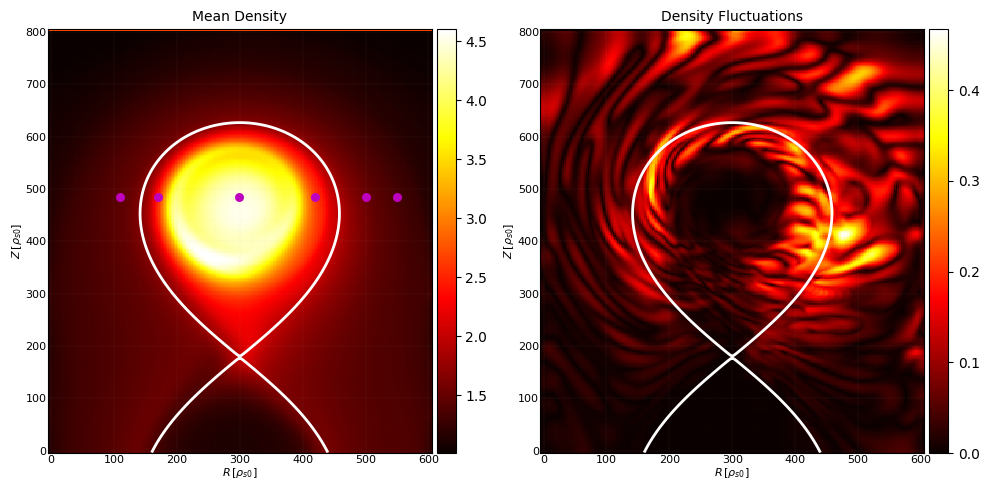

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)

# First subplot (left) - cs1
ax1 = axes[0]
cs1 = ax1.pcolormesh(X, Y, np.exp(np.mean(loaded_data, axis=(0,1))), cmap='hot', shading='auto')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cbar1 = fig.colorbar(cs1, cax=cax1, orientation='vertical')
cbar1.ax.tick_params(labelsize=10)

# Add X-point contour
ax1.contour(X, Y, Psi, levels=[Psi[iyxpt, ixxpt]], colors='w', linewidths=2, linestyles='-')
ax1.scatter(110, 483.75, c='m', marker='o', s=20, edgecolors='m', linewidth=2) 
ax1.scatter(170, 483.75, c='m', marker='o', s=20, edgecolors='m', linewidth=2) 
ax1.scatter(298.75, 483.75, c='m', marker='o', s=20, edgecolors='m', linewidth=2) 
ax1.scatter(420, 483.75, c='m', marker='o', s=20, edgecolors='m', linewidth=2) 
ax1.scatter(500, 483.75, c='m', marker='o', s=20, edgecolors='m', linewidth=2) 
ax1.scatter(550, 483.75, c='m', marker='o', s=20, edgecolors='m', linewidth=2) 


# Styling for first subplot
ax1.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
ax1.grid(True, which='minor', alpha=0.2, linestyle=':', linewidth=0.1)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(axis='x', labelsize=8, pad=1)
ax1.tick_params(axis='y', labelsize=8, pad=1)
ax1.tick_params(which='minor', direction="in", size=0)
ax1.tick_params(which='major', direction="in", size=0)
ax1.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=8, labelpad=1)
ax1.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=8, rotation=90, labelpad=1)
ax1.set_title('Mean Density', fontsize=10)

# Second subplot (right) - cs2
ax2 = axes[1]
cs2 = ax2.pcolormesh(X, Y, loaded_data_fluct_avg, cmap='hot', shading='auto')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cbar2 = fig.colorbar(cs2, cax=cax2, orientation='vertical')
cbar2.ax.tick_params(labelsize=10)

# Add X-point contour to second subplot
ax2.contour(X, Y, Psi, levels=[Psi[iyxpt, ixxpt]], colors='w', linewidths=2, linestyles='-')

# Styling for second subplot
ax2.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
ax2.grid(True, which='minor', alpha=0.2, linestyle=':', linewidth=0.1)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(axis='x', labelsize=8, pad=1)
ax2.tick_params(axis='y', labelsize=8, pad=1)
ax2.tick_params(which='minor', direction="in", size=0)
ax2.tick_params(which='major', direction="in", size=0)
ax2.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=8, labelpad=1)
ax2.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=8, rotation=90, labelpad=1)
ax2.set_title('Density Fluctuations', fontsize=10)

plt.tight_layout()
plt.show()